In [1]:
from glob import glob
import os as os
import json
import matplotlib.pyplot as plt  
import matplotlib as mpl  
import autograd.numpy as np
from autograd import grad
import pandas as pd
import scipy as scipy
import time

np.random.seed(123)
%matplotlib inline

import keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV

import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
directories = [name for name in os.listdir("/home/a0121533/fyp2017dsap/slides/") if os.path.isdir(os.path.join("/home/a0121533/fyp2017dsap/slides/", name))]
slide_files = []

for d in directories:
    slide_path = "/home/a0121533/fyp2017dsap/slides/" + d + "/" 
    list_of_slides = glob(slide_path + "*.svs")
    
    if len(list_of_slides) != 0:
        slide_file_name = glob(slide_path + "*.svs")[0] # one slide in each directory
        slide_files.append(slide_file_name)

In [3]:
import json

with open('purity_score.json') as json_data:
    d = json.load(json_data)
    
keys = d.keys()

purity_dict = {}

for key in keys:
    purity_dict[key[:16]] = d[key]

In [4]:
def generate_data(data_type):
    read_tiles_path = "/home/a0121533/fyp2017dsap/tiles/" + data_type + "/"
    tiles = glob(read_tiles_path + "*.png")    
    
    img_matrix_array = []
    purity_scores = []
    
    for tile in tiles:
        # read slide name from tile [slide_name]_[slide_index].png score value
        slide_name = tile[tile.rfind('/')+1:tile.rfind('/')+17]
        
        if slide_name in purity_dict:
            purity_score = purity_dict[slide_name]
            purity_scores.append(purity_score)

            tile_data = mpimg.imread(tile)
            img_matrix_array.append(tile_data)
    
    return np.asarray(img_matrix_array), np.asarray(purity_scores)

In [5]:
def encode_data(train_data, test_data):
    input_img = Input(shape=(256,256,3), name = 'input_img')
    x = Conv2D(128, (3, 3), activation='elu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    encoded = Flatten()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='elu',padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    #print(autoencoder.summary())
    autoencoder.compile(optimizer='adam', loss='mse')
    encoder = Model(input_img, encoded)
    print(encoder.summary())
    hfit = autoencoder.fit(x=train_data, y=train_data, validation_split = 0.3,
                           epochs=10, batch_size=16, shuffle=True)
    
    decoded_tiles = autoencoder.predict(test_data)
    
    num_tiles = 5  
    plt.figure(figsize=(20, 4))
    for i in range(num_tiles):
        
        ax = plt.subplot(2, num_tiles, i + 1)
        plt.imshow(test_data[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, num_tiles, i + 1 + num_tiles)
        plt.imshow(decoded_tiles[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    return np.array(encoder.predict(train_data)), np.array(encoder.predict(test_data))

In [6]:
results_dict = {"mse_dist": [],
                "shuffle_mse_dist": []
                }

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.02,
    height_shift_range=0.02,
    rotation_range=4)

test_datagen = ImageDataGenerator()

In [29]:
from keras.regularizers import l1
from keras import optimizers


def init_model():
    model = Sequential()
    model.add(Dense(1, input_dim=1024, 
                    kernel_initializer='normal',
                    activation = 'sigmoid', 
                    activity_regularizer=keras.regularizers.l1(1e-6)))
    model.compile(loss='mse',
                  optimizer=keras.optimizers.SGD(lr=1e-5))
    return model

from scipy import stats

def generate_mse_boxplot(results):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(1,1,1)
    mse_dist = results['mse_dist']
    shuffle_dist = results['shuffle_mse_dist']
    medians = [np.median(mse_dist), np.median(shuffle_dist)]
    plt.boxplot([mse_dist, shuffle_dist], labels=['Informative', 'Non-informative'], showmeans=True)
    
    pos = np.arange(2) + 1
    upperLabels = [str(np.round(s, 4)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(2), ax.get_xticklabels()):
        k = tick % 2
        ax.text(pos[tick], max(mse_dist+shuffle_dist)+0.0005, upperLabels[tick],
                 horizontalalignment='center', size='large')
    
    plt.title("Boxplot of Purity Score Prediction", fontsize=18)
    return plt

Obtaining tile and labels
(2110, 256, 256, 3)
(2110,)
(973, 256, 256, 3)
(973,)
Generating training data
Generating test data
Fitting Encoder
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        18464     


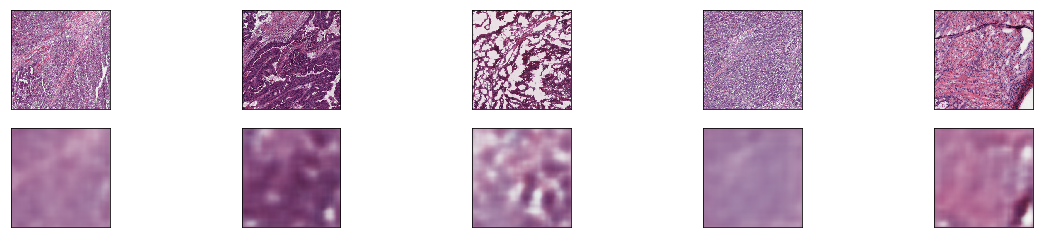

Sanity Check
y_train: (2110,)
y_test: (973,)
x_train_encoded: (2110, 1024)
x_test_encoded: (973, 1024) 

Shuffle 1
Splitting data
Fitting model #1
Train on 1899 samples, validate on 875 samples
Epoch 1/100
1899/1899 [==============================] - 0s - loss: 0.0360 - val_loss: 0.0385
Epoch 2/100
1899/1899 [==============================] - 0s - loss: 0.0359 - val_loss: 0.0383
Epoch 3/100
1899/1899 [==============================] - 0s - loss: 0.0358 - val_loss: 0.0382
Epoch 4/100
1899/1899 [==============================] - 0s - loss: 0.0357 - val_loss: 0.0381
Epoch 5/100
1899/1899 [==============================] - 0s - loss: 0.0356 - val_loss: 0.0380
Epoch 6/100
1899/1899 [==============================] - 0s - loss: 0.0355 - val_loss: 0.0379
Epoch 7/100
1899/1899 [==============================] - 0s - loss: 0.0354 - val_loss: 0.0378
Epoch 8/100
1899/1899 [==============================] - 0s - loss: 0.0354 - val_loss: 0.0377
Epoch 9/100
1899/1899 [==============================]

In [8]:
np.random.seed(123)

print("Obtaining tile and labels")
# generate tile and labels
x_train, y_train = generate_data("train")
print(x_train.shape)
print(y_train.shape)

x_test, y_test = generate_data("test")
print(x_test.shape)
print(y_test.shape)

print("Generating training data")
for x_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=x_train.shape[0]):
    x_train = x_batch
    y_train = y_batch
    break 

print("Generating test data")
for x_batch, y_batch in test_datagen.flow(x_test, y_test, batch_size=x_test.shape[0]):
    x_test = x_batch
    y_test = y_batch
    break 

print("Fitting Encoder")
x_train_encoded, x_test_encoded = encode_data(x_train, x_test)

print("Sanity Check")
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("x_train_encoded:", x_train_encoded.shape)
print("x_test_encoded:", x_test_encoded.shape, "\n")

y_train_correct = y_train.copy()
train_size = x_train_encoded.shape[0]
test_size = x_test_encoded.shape[0]

for i in range(50):
    print("Shuffle", str(i+1))
    start_time = time.time()

    # split data
    print("Splitting data")

    num_train = int(0.9*train_size)
    num_test = int(0.9*test_size)

    train_indices = np.random.choice(train_size, num_train, replace=False)
    test_indices = np.random.choice(test_size, num_test, replace=False)

    x_train_split = x_train_encoded[train_indices,]
    y_train_split = y_train_correct[train_indices,]

    x_test_split = x_test_encoded[test_indices,]
    y_test_split = y_test[test_indices,]

    print("Fitting model #1")
    model = init_model()
    mfit = model.fit(x_train_split, y_train_split, epochs=100,
              batch_size=16, 
              validation_data=(x_test_split,y_test_split), 
              shuffle=True)

    print("Testing model #1")
    mse = mfit.history["val_loss"][-1]
    results_dict['mse_dist'].append(mse)

    # shuffle y_train to get silly mse
    print("Shuffling y_train")
    print("Before:", y_train_split)
    np.random.shuffle(y_train_split)
    print("After:", y_train_split)

    model_ = init_model()
    print("Fitting model #2")
    mfit_ = model_.fit(x_train_split, y_train_split, epochs=100,
                batch_size=16, verbose=0, 
               validation_data=(x_test_split,y_test_split),
               shuffle=True)

    print("Testing model #2")
    mse_ = mfit_.history["val_loss"][-1]
    count = 0
    while mse_ < mse and count < 4:
        np.random.shuffle(y_train_split)
        model_ = init_model()
        mfit_ = model_.fit(x_train_split, y_train_split, epochs=100,
                batch_size=16, verbose=0, 
               validation_data=(x_test_split,y_test_split),
               shuffle=True)
        mse_ = mfit_.history["val_loss"][-1]
        count += 1
        
    results_dict['shuffle_mse_dist'].append(mse_)

    print("mse:", str(mse), "mse_:", str(mse_))

import json
with open('permutation_results.json', 'w') as fp:
    json.dump(results_dict, fp)

<module 'matplotlib.pyplot' from '/home/a0121533/.virtualenvs/keras/lib/python3.5/site-packages/matplotlib/pyplot.py'>

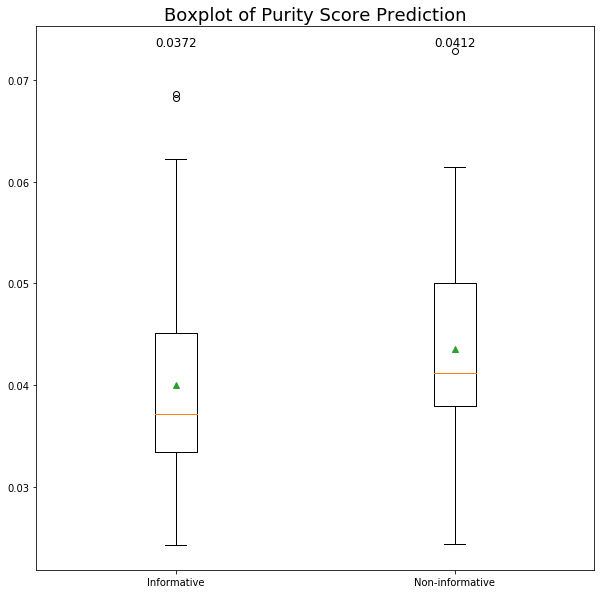

In [30]:
generate_mse_boxplot(results_dict)